In [1]:
from typing import Iterable, Tuple
import warnings
from multiprocessing import Pool
from pathlib import Path
import json

import numpy as np  
from scipy.interpolate import RegularGridInterpolator

# Support for interactive widgets
from IPython.display import *
from ipywidgets import Dropdown

# %matplotlib widget 
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astroquery.simbad import Simbad

from deblib.constants import c

from dust_extinction.parameter_averages import F99, F04, G23

import emcee
from emcee.autocorr import AutocorrError
import corner

from libs.mistisochrones import MistIsochrones, Phase
from libs.mcmc_sed import ln_prob, min_max_normalize
from libs import extinction
from libs.sed import get_sed_for_target, create_outliers_mask

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


### Load the PySSED bt-settle model and set up the related SED functions 

__Note:__ The data file is currently a copy of that kindly published on [GitHub](https://github.com/iain-mcdonald/PySSED)
by [McDonald at al., (2024)](https://ui.adsabs.harvard.edu/abs/2024RASTI...3...89M/abstract)

First we load the pre-built data of bt-settle synthetic SED which have previously been parsed
and saved with the `makemodel.py` module. The data file contains fluxes over a range of filters
for combinations of $T_{\rm eff}$, $\log{g}$, $[{\rm Fe/H}]$ and $[{\rm \alpha/Fe}]$. We build a
table in memory which holds a `RegularGridInterpolator` for each filter, with the dimensions/axes
being the $T_{\rm eff}$ and $\log{g}$ values and the values being the corresponding fluxes.

For now we consider only the data for solar metallicity, hence the interpolators only cover
$[{\rm Fe/H}] = 0$ and $[{\rm \alpha/Fe}] = 0$, however additional axes/dimensions
for $[{\rm Fe/H}]$ and $[{\rm \alpha/Fe}]$ may be added, if required.

In [2]:
# Read the pre-built bt-settl model file
model_grid = np.genfromtxt("libs/data/pyssed/model-bt-settl-recast.dat",
                           names=True, delimiter=" ", deletechars=" ~!@#$%^&*()=+~\|]}[{';: ?>,<")

# For now we're only interested in the solar metallicity model fluxes
model_grid = model_grid[(model_grid["metal"] == 0) & (model_grid["alpha"] == 0)]
model_grid.sort(order=["teff", "logg"]) # Should already be in this order, but just in case

# Set up a table of interpolators, one per filter. Each interpolator is based on a pivot table
# with the teffs and loggs as the axes and filter fluxes as the values.
known_filters = list(model_grid.dtype.names)[5:]
teffs, teff_ixs = np.unique(model_grid["teff"], return_inverse=True)
loggs, logg_ixs = np.unique(model_grid["logg"], return_inverse=True)
model_interps = np.empty(shape=(len(known_filters), ), dtype=[("filter", object), ("interp", object)])
for filt_ix, filter in enumerate(known_filters):
    tl_pivot = np.zeros((len(teffs), len(loggs)), dtype=model_grid[filter].dtype)
    tl_pivot[teff_ixs, logg_ixs] = model_grid[filter]
    model_interps[filt_ix] = (filter, RegularGridInterpolator((teffs, loggs), tl_pivot, "linear"))
del model_grid

model_wl_range = (0.5, 25) * u.um
model_teff_range = (min(teffs), max(teffs)) * u.K
model_logg_range = (min(loggs), max(loggs)) * u.dex
print(f"Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:")
print(f"wavelength {model_wl_range}, Teff {model_teff_range} and logg {model_logg_range}")

Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:
wavelength [ 0.5 25. ] um, Teff [ 1900. 70000.] K and logg [-0.5  6. ] dex


This is the `spec_func` for use by the MCMC `model_func`. It interpolates and returns
synthetic SED flux values for chosen filters at the requested $T_{\rm eff}$ and $\log{g}$.

In [3]:
# Helps translates filter names from the SED service to the equivalent filters in model_interps
with open("libs/data/pyssed/sed-filter-translation.json", "r", encoding="utf8") as j:
    sed_filter_translator = json.load(j)

def get_filter_interpolators_and_mappings(filters: Iterable[str]) \
        -> Tuple[Iterable[RegularGridInterpolator], Iterable[int]]:
    """
    Takes the passed list of filters and returns a list of interpolators, one for each unique filter
    listed, and a second list of indices which map these interpolators back to the original list.

    This allows us to avoid repeating this lookup/mapping within a MCMC run.

    :filters: a list of filters to locate and map
    :returns: (list of interpolators, the mappings to the input list)
    """
    # Here np.unique return 2 lists; one of unique values & 2nd of indices mapping them onto input.
    # We use the first list to locate the interpolator corresponding to each unique filter, and we
    # use the second list of indices to map the interpolators onto the output fluxes it generates.
    unique_filters, input_map = np.unique(filters, return_inverse=True)
    interps = np.empty(len(unique_filters), dtype=object)
    for filter_ix, filter in enumerate(unique_filters):
        name = sed_filter_translator.get(filter, filter)
        interps[filter_ix] = model_interps[model_interps["filter"] == name]["interp"][0]
    return interps, input_map

In [4]:
def get_model_fluxes(filter_interps: Iterable[RegularGridInterpolator],
                     flux_mappings: Iterable[int],
                     teff: float,
                     logg: float) -> Iterable[float]:
    """
    Will return a ndarray of flux values calculated by the filters corresponding to the
    interpolators. The filter_interps and flux_mappings are effectively the return values
    from the get_filter_interpolators_and_mappings() function. This is separated out to avoid
    repeating the same lookup for every attempted fit.

    It's not obvious in the data file, but the scale of the values implies the fluxes are in Jy

    :filter_interps: unique list of interpolators to use to generate flux values
    :flux_mappings: mapping indices from the interpolators onto the output
    :teff: the effective temperature for the fluxes
    :logg: the logg for the fluxes
    """
    # Generate each unique flux value
    xi = (teff, logg)
    fluxes_by_filter = np.empty((len(filter_interps)), dtype=float)
    for filter_flux_ix, filter in enumerate(filter_interps):
        fluxes_by_filter[filter_flux_ix] = filter(xi=xi)

    # Copy the fluxes to the output via the mappings
    return_fluxes = np.empty((len(flux_mappings)), dtype=float)
    for flux_ix, flux_mapping in enumerate(flux_mappings):
        return_fluxes[flux_ix] = fluxes_by_filter[flux_mapping]
    return return_fluxes

In [5]:
# Test the above
test_filters = ['Johnson:V', 'Gaia:G', 'Gaia:G', '2MASS:J', 'Johnson:J', 'Johnson:J', 'Johnson:H',
                '2MASS:H', '2MASS:Ks', 'Johnson:K', 'WISE:W1', 'WISE:W3', 'WISE:W3']
filter_interps, flux_mappings = get_filter_interpolators_and_mappings(test_filters)
fluxes = get_model_fluxes(filter_interps, flux_mappings, 5750., 4.44)
print(fluxes)

[8.26772e+18 8.82360e+18 8.82360e+18 1.04926e+19 1.04820e+19 1.04820e+19
 9.29786e+18 9.28118e+18 6.24596e+18 6.18728e+18 2.89262e+18 2.55888e+17
 2.55888e+17]


Prototype outlier detection function

### Load the MIST isochrones
The MIST isochrones are used to get $R$, $T_{\rm eff}$ and $\log{(g)}$ values for given stellar
mass and age combinations. The radii are evaluated against the $k$ prior, and the $T_{\rm eff}$
and $\log{(g)}$ values are the parameters required to sample the NewEra spectra for fitting.

In [6]:
# To reduce the number of variable we assume solar metallicity
mist_isos = MistIsochrones(metallicities=[0])

Reading in: /home/steveo/projects/main/platodebcat/libs/data/mist/MIST_v1.2_vvcrit0.4_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_basic.iso


### Set up the extinction model

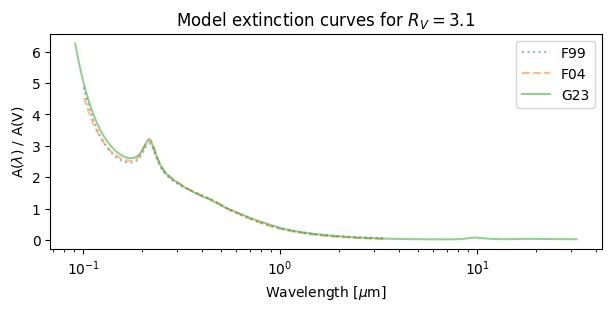

Using the G23 extinction model covers the range from 0.0912 um to 32.0 um.


In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
for (_mod, _ls) in [(F99, ":"), (F04, "--"), (G23, "-")]:
    _lambda = (1 / np.logspace(*np.log10(_mod.x_range), num=1000)) * u.um
    ax.plot(_lambda, _mod(Rv=3.1)(_lambda), ls=_ls, alpha=0.5, label=f"{_mod.name}")
ax.set(title=f"Model extinction curves for $R_V=3.1$", xscale="log",
       xlabel=r"Wavelength [$\mu$m]", ylabel=r"A($\lambda$) / A(V)")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

# The G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model covers the range from",
      f"{min(ext_wl_range)} to {max(ext_wl_range)}.")

### Select our target and get its known information

In [8]:
default_target = "CM Dra"
targets_config_file = Path.cwd() / "config" / "fitting-a-sed-targets.json"
with open(targets_config_file, mode="r", encoding="utf8") as f:
    full_dict = json.load(f)
targets_cfg = { k: full_dict[k] for k in full_dict if full_dict[k].get("enabled", True) }

max_teff = max(model_teff_range).value
options = [
    (f"{t}" + (" *" if c.get("exclude", False) else "") + (" [too hot!]" if min(c["TeffA"], c["TeffB"]) > max_teff else ""), t)
        for t, c in targets_cfg.items()
]

target_selection = Dropdown(options=options, value=default_target, description="Targets:")
display(target_selection)

Dropdown(description='Targets:', index=31, options=(('V436 Per', 'V436 Per'), ('V539 Ara', 'V539 Ara'), ('MU C…

In [9]:
target = target_selection.value
target_config = targets_cfg[target]
search_term = target_config.get("search_term", target)
k, k_err = target_config.get("k"), target_config.get("k_err", 0)

# initial Temps for fitting. For now known values rounded to nearest 100 K
teffs0 = np.round(np.array([target_config["TeffA"], target_config["TeffB"]]) / 100) * 100

# We need the coordinates and approximate distance for extinction lookups
simbad = Simbad()
simbad.add_votable_fields("parallax")
if _tbl := simbad.query_object(search_term):
    target_coords = SkyCoord(ra=_tbl["ra"][0] * _tbl["ra"].unit,
                             dec=_tbl["dec"][0] * _tbl["dec"].unit,
                             distance=1000 / _tbl["plx_value"][0] * u.pc)
    print(f"{target} SkyCoords are {target_coords}")

CM Dra SkyCoords are <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (248.58470944, 57.1623247, 14.86157925)>


### Get the SED data for the target
- apply default uncertainties to those measurements with none
- exclude measurements outside the range of our extinction model
- exclude outliers

In [10]:
# Read in the SED for this target
sed = get_sed_for_target(target, search_term, radius=0.1)
print(f"Retrieved {len(sed)} SED observation(s) for {target}")

# Filter SED to those covered by our models and also remove any outliers
model_mask = np.array([f in sed_filter_translator for f in sed["sed_filter"]])
model_mask &= (sed["sed_wl"] >= min(ext_wl_range)) & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(model_wl_range)) & (sed["sed_wl"] <= max(model_wl_range))
out_mask = create_outliers_mask(sed, teffs0, min_unmasked=0.9)

if "CM Dra" in target: # TODO: investigate why not being picked up in create_outliers_mask
    out_mask |= sed["sed_filter"] == "WISE:W4"

# De-duplicate the SED. Measurements often appear multiple times in these data, and to counter
# this we only retain the first instance of each unique combination of filter/flux/eflux value.
sed = sed[model_mask & ~out_mask].group_by(keys=["sed_filter", "sed_flux", "sed_eflux"])
sed = sed[sed.groups.indices[:-1]]
sed.sort(["sed_wl"])
print(f"{len(sed)} unique SED observation(s) retained after filtering and de-duplication")

Retrieved 28 SED observation(s) for CM Dra
15 unique SED observation(s) retained after filtering and de-duplication


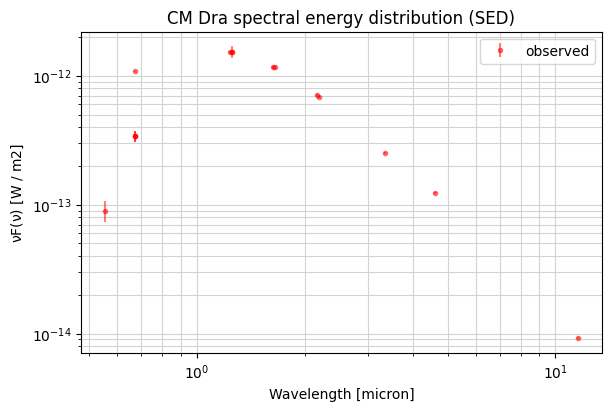

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed["sed_wl"], sed["sed_vfv"], sed["sed_evfv"], fmt=".r", alpha=0.5, label="observed")
ax.set(title=f"{target} spectral energy distribution (SED)",
       xscale="log", xlabel=f"Wavelength [{sed['sed_wl'].unit}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{sed['sed_vfv'].unit}]")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### De-redden the SED

In [12]:
for val, flags in extinction.get_extinction(target_coords):
    if val and not np.isnan(val) and flags.get("converged", False):
        print(f"Found extinction with {flags['source']}: {flags.get('type', '')} = {val:.6f}")
        if flags.get("type", "") == "B(B-V)":
            sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Ebv=val)
        else:
            sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Av=val)
        break

if "sed_der_flux" in sed.colnames:
    der_lab = "dereddened"
else:
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"

Found extinction with get_gontcharov_ebv: E(B-V) = 0.015330


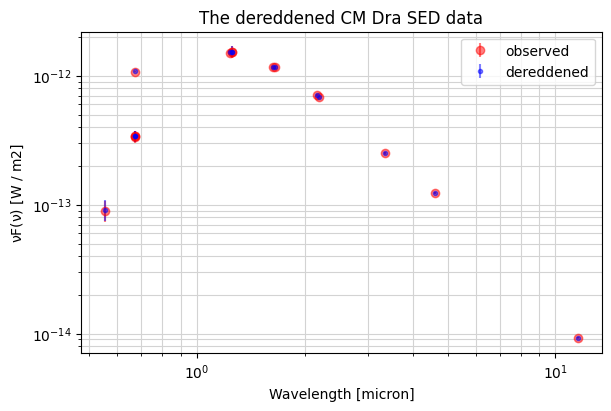

In [13]:
# Create a dereddened vF(v) column for plotting
sed["sed_der_vfv"] = sed["sed_der_flux"] * sed["sed_freq"] * u.Hz

fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed["sed_wl"], sed["sed_vfv"], sed["sed_evfv"], fmt="or", alpha=0.5, label="observed")
ax.errorbar(sed["sed_wl"], sed["sed_der_vfv"], sed["sed_evfv"], fmt=".b", alpha=0.5, label=der_lab)
ax.set(title=f"The dereddened {target} SED data",
       xscale="log", xlabel=f"Wavelength [{sed['sed_wl'].unit}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{sed['sed_der_vfv'].unit}]")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### Set up the MCMC functions

- `lnlike` is the _likelihood function_ which compares the model spectra with the observed data.
Its behaviour is fixed so this function is part of the `mcmc_sed` module
- `lnprior` contains any _prior knowledge_ we have about the parameters from elsewhere __and is defined here__
  - in this case there are restrictions on stellar age/phase and a known ratio of radii from LC fitting
  - must returns a blob containing the two stars' $T_{\rm eff}$ and $\log{g}$ values for masses and age being evaluated
  for passing on to the corresponding model function
- `lnprob` combines the two into a probability density. Again the behaviour is fixed so this
function is part of the `mcmc_sed` module

In [14]:
MIN_MASS, MAX_MASS = 0.1, 270.      # realistic MIST mass range
MIN_PHASE, MAX_PHASE = Phase.MS, Phase.MS
mist_ages = mist_isos.list_ages(feh=0, min_phase=MIN_PHASE, max_phase=MAX_PHASE)
MIN_AGE, MAX_AGE = min(mist_ages), max(mist_ages)
MIN_TEFF, MAX_TEFF = model_teff_range.value
MIN_LOGG, MAX_LOGG = model_logg_range.value
MIST_PRIOR_PARAMS = ["Teff", "log_g", "R"]

# Target specific priors
k_flex = max(k * 0.05, k_err)
print(f"Priors from fitting: k={k:f} +/- flex of {k_flex:f}")

def ln_prior(MA: float, MB: float, age: float):
    """
    The MCMC log prior function which evaluates the properties of the stars defined by
    the current masses and age against known prior constraints.

    Note: the MCMC walkers are exploring stellar masses and age (theta), which we use to find the
    corresponding effective temp, logg and radius for evaluating priors & to generate model spectra.
    """
    # pylint: disable=too-many-locals
    TeffA, TeffB, loggA, loggB = None, None, None, None
    retval = -np.inf # failure

    # Basic validation of priors; lookup won't work if these are out of range of MIST values
    if MIN_MASS <= MA <= MAX_MASS and MIN_MASS <= MB <= MAX_MASS and MIN_AGE <= age <= MAX_AGE:
        try:
            # Get the stellar params to evaluate, plus the Teffs/logg are req'd to generate SEDs
            TeffA, loggA, RA = mist_isos.stellar_params_for_mass(0, age, MA, MIST_PRIOR_PARAMS, MIN_PHASE, MAX_PHASE)
            TeffB, loggB, RB = mist_isos.stellar_params_for_mass(0, age, MB, MIST_PRIOR_PARAMS, MIN_PHASE, MAX_PHASE)

            # Evaluate against priors; in the case of k (ratio of radii) prior is specific to target
            if np.abs((RB / RA) - k) <= k_flex \
                and min(TeffA, TeffB) >= MIN_TEFF and max(TeffA, TeffB) <= MAX_TEFF \
                and min(loggA, loggB) >= MIN_LOGG and max(loggA, loggB) <= MAX_LOGG:
                retval = 0 # params conform to the priors
        except ValueError: # If lookup fails with no match
            pass
    # Return whether the priors are happy (0) and also the revised theta for use by model_func
    return retval, (TeffA, TeffB, loggA, loggB)

# This is passed to EnsembleSampler to define the format of the set of blobs returned from the calls
# to ln_prior() once the ensemble has completed. With this get_blobs() returns a structured array.
blobs_dtype = [("TeffA", float), ("TeffB", float), ("loggA", float), ("loggB", float)]

Priors from fitting: k=0.945000 +/- flex of 0.047250


#### Prepare and run the MCMC

In [15]:
# Mimic basic pre-processing which gives broad insight into the nature of the target
# Starting position for the search - round known masses to nearest 0.5 M_sun
init_sigma = 0.1
init_MA = max(MIN_MASS + init_sigma, round(target_config["MA"] * 2) / 2)
init_MB = max(MIN_MASS + init_sigma, round(target_config["MB"] * 2) / 2)
init_age = 9.0 if min(init_MA, init_MB) < 2.0 else 8.0
print(f"MCMC init pos: MA = {init_MA:.6f} & MB = {init_MB:.6f} [M_sun], log(age) = {init_age} [dex(yr)]")

MCMC init pos: MA = 0.200000 & MB = 0.200000 [M_sun], log(age) = 9.0 [dex(yr)]


In [16]:
nwalkers = 100
niters = 50000

rng = np.random.default_rng(42)
initial = np.array([init_MA, init_MB, init_age])
ndim = len(initial)
p0 = [initial + rng.normal(0, init_sigma, ndim) for _ in range(nwalkers)] # wants a list of ndarrays

# These are the functions for generating synthetic spectra and combining them into a model
# Dangerous to ignore x for direct access to filter_interps & flux_mappings, but faster
filter_interps, flux_mappings = get_filter_interpolators_and_mappings(sed["sed_filter"])
flux_unit = sed["sed_der_flux"].unit
y_log = np.log10(sed["sed_der_flux"].value)
def model_func(x, Teff1, Teff2, logg1, logg2):
    # Scale the model to the obs' in log10 space as the range of potential values is very wide
    y_model_log = np.log10(np.add(get_model_fluxes(filter_interps, flux_mappings, Teff1, logg1),
                                  get_model_fluxes(filter_interps, flux_mappings, Teff2, logg2)))
    if flux_unit != u.Jy:
        y_model_log -= 26
    return 10**(y_model_log + np.median(y_log - y_model_log))

# These are the "fixed" kwargs which will be sent to the MCMC ln_prob function
kwargs = {
    "x": None, #(filter_interps, flux_mappings), # ignored in this implementation
    "y": sed["sed_der_flux"].value,
    "y_err": sed["sed_eflux"].value,
    "ln_prior_func": ln_prior,
    "model_func": model_func
}

In [17]:
with warnings.catch_warnings(category=RuntimeWarning):
    warnings.filterwarnings("ignore", message="invalid value encountered in scalar subtract")
    with Pool(processes=None) as pool:
        print(f"Running MCMC for {niters:,} iterations with {nwalkers} walkers.")
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=ln_prob, kwargs=kwargs,
                                        blobs_dtype=blobs_dtype, pool=pool)
        state = sampler.run_mcmc(p0, niters, progress=True)

Running MCMC for 50,000 iterations with 100 walkers.


100%|██████████| 50000/50000 [13:02<00:00, 63.91it/s]


In [18]:
accept_frac = np.mean(sampler.acceptance_fraction)
print(f"Mean Acceptance fraction: {accept_frac:.6f}")

with warnings.catch_warnings(category=RuntimeWarning):
    warnings.filterwarnings("ignore", message="invalid value encountered in divide")
    try:
        # autocorrelation time; steps to effectively "forget" start position
        tau = sampler.get_autocorr_time(c=1)
        print(f"Autocorrelation steps:   ", ", ".join(f"{t:.3f}" for t in tau))
    except AutocorrError as err:
        print(f"\033[93m\033[1m{err}\033[0m")
        tau = err.tau

Mean Acceptance fraction: 0.103885
Autocorrelation steps:    nan, nan, nan


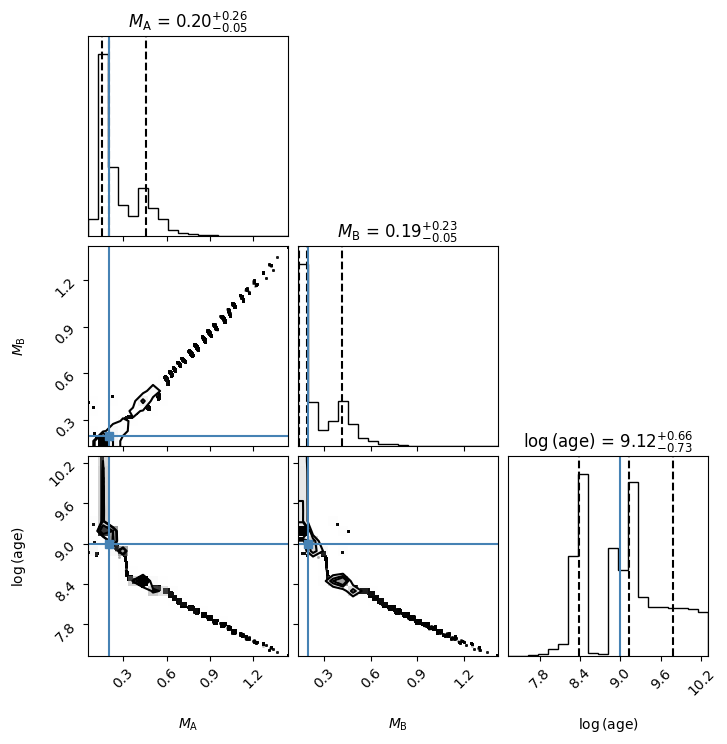

In [19]:
warm_discard = int(np.mean(np.nan_to_num(tau, copy=True, nan=1000))) * 2
thin = max(1, int(1 / (1-max(accept_frac, 0.1))))

# thin; every nth step from the chain
samples = sampler.get_chain(discard=warm_discard, thin=thin, flat=True)
fig = corner.corner(samples, show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84],
                    labels=[r"$M_{\rm A}$", r"$M_{\rm B}$", r"$\log{({\rm age})}$"],
                    truths=[init_MA, init_MB, init_age])
plt.show(fig)
plt.close(fig)

In [20]:
# Gets the median fitted values (currently M1, M2 and log(age))
fitted_vals = np.median(samples, axis=0)
fitted_high = np.quantile(samples, 0.84, axis=0) - fitted_vals
fitted_low = fitted_vals - np.quantile(samples, 0.16, axis=0)

print(f"Best fit parameters for {target} from {niters:,} MCMC iterations")
for ix, (k, unit) in enumerate([("MA", u.solMass), ("MB", u.solMass), ("age", u.dex(u.yr))]):
    print(f"{k:>9s} = {fitted_vals[ix]:.3f} +/- {fitted_high[ix]:.3f}/{fitted_low[ix]:.3f} {unit}",
          f"(known value {target_config.get(k, np.NaN)} +/- {target_config.get(k+'_err', '')})")

Best fit parameters for CM Dra from 50,000 MCMC iterations
       MA = 0.197 +/- 0.262/0.049 solMass (known value 0.231 +/- 0.0009)
       MB = 0.189 +/- 0.225/0.051 solMass (known value 0.2141 +/- 0.001)
      age = 9.124 +/- 0.659/0.735 dex(yr) (known value 9.9 +/- )


Plotting Star A where Teff = 3083 K and logg = 5.138
PLotting Star B where Teff = 3072 K and logg = 5.143


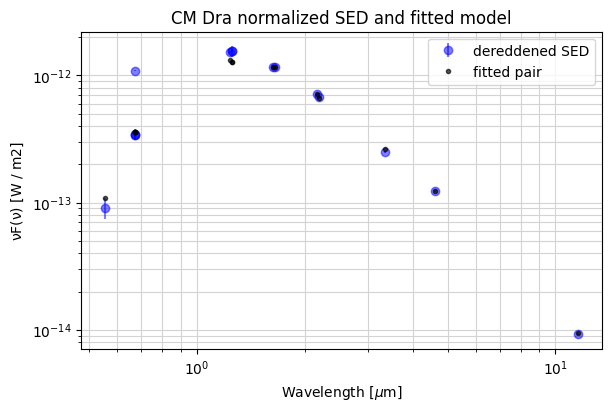

In [21]:
# Need to get the effective temperatures & logg for these masses/age combinations
MA, MB, log_age = fitted_vals
teffA, loggA = mist_isos.stellar_params_for_mass(0, log_age, MA, ["Teff", "log_g"], MIN_PHASE, MAX_PHASE)
teffB, loggB = mist_isos.stellar_params_for_mass(0, log_age, MB, ["Teff", "log_g"], MIN_PHASE, MAX_PHASE)

print(f"Plotting Star A where Teff = {teffA:.0f} K and logg = {loggA:.3f}")
print(f"PLotting Star B where Teff = {teffB:.0f} K and logg = {loggB:.3f}")

# Generate a model SED from the fitted values for plotting
# TODO: show fluxes for each star, using ratio of stars' fluxes (call get_model_fluxes) and comb_vfv
sed_freq = sed["sed_freq"].value
mod_comb_flux = model_func(sed_freq, teffA, teffB, loggA, loggB)
mod_comb_vfv = mod_comb_flux * sed_freq

# Plot the fitted model against the derredened SED + show each star's contribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
for (lam,           flux,               eflux,              fmt,    alpha,  z,      label) in [
    (sed["sed_wl"], sed["sed_der_vfv"], sed["sed_evfv"],    "ob",   0.5,    50,     "dereddened SED"),
    (sed["sed_wl"], mod_comb_vfv,       None,               ".k",   0.66,   90,     "fitted pair"),
]:
    # Rather than (flux-min(flux))/norm_scale we plot flux/norm_scale so that we don't loose the lowest value to zero
    ax.errorbar(lam, flux, eflux, fmt=fmt, alpha=alpha, zorder=z, label=label)
ax.set(title=f"{target} normalized SED and fitted model", xscale="log", yscale="log",
       xlabel=r"Wavelength [$\mu$m]", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{sed['sed_der_vfv'].unit}]")
ax.grid(True, which="both", axis="both", color="lightgray", zorder=0)
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)